In [ ]:
pip install -r "..\requirements.txt"

In [2]:
# 1. Setup
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# MLP (Keras)
import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# XAI-Tools
import shap
import lime
import lime.lime_tabular
import dice_ml
from alibi.explainers import AnchorTabular

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Daten laden & vorverarbeiten

import pandas as pd

# Dataset laden
df = pd.read_csv("loan_data.csv")

# Erste Zeilen anzeigen
display(df.head())

# Label- und Feature-Spalten trennen
TARGET = "loan_status"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Kategorische Features identifizieren
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Kategorische Spalten:", cat_cols)
print("Numerische Spalten:", num_cols)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Kategorische Spalten: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerische Spalten: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


In [4]:
# One-Hot-Encoding für kategoriale Spalten
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Skalierung der numerischen Spalten
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_enc[num_cols] = scaler.fit_transform(X_enc[num_cols])

# Prüfen
display(X_enc.head())


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_male,person_education_Bachelor,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,-0.953538,-0.104090,-0.892284,4.024953,1.683039,4.016394,-0.739109,-1.419814,False,False,...,True,False,False,True,False,False,False,True,False,False
1,-1.118963,-0.846005,-0.892284,-1.359209,0.044782,-0.684829,-0.996863,-2.549975,False,False,...,False,False,True,False,True,False,False,False,False,True
2,-0.457264,-0.844065,-0.397517,-0.646600,0.625557,3.443074,-0.739109,0.047412,False,False,...,False,False,False,False,False,False,True,False,False,False
3,-0.788113,-0.007039,-0.892284,4.024953,1.417829,3.443074,-0.996863,0.840507,False,True,...,False,False,False,True,False,False,True,False,False,False
4,-0.622689,-0.176371,-0.727362,4.024953,1.095549,4.475050,-0.481354,-0.924130,True,False,...,True,False,False,True,False,False,True,False,False,False


In [5]:
# 2. Trainings- / Test-Split
from sklearn.model_selection import train_test_split

# zusätzlich zum bereits existierenden X_enc:
X_raw = df.drop(columns=[TARGET])
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=SEED, stratify=y
)
# Und separat noch den kodierten Split wie gehabt:
X_train, X_test, _, _ = train_test_split(
    X_enc, y, test_size=0.3, random_state=SEED, stratify=y
)

print("Train-Set:", X_train.shape, "Test-Set:", X_test.shape)


Train-Set: (31500, 22) Test-Set: (13500, 22)


Decision Tree Accuracy: 0.9088148148148149
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10500
           1       0.85      0.72      0.78      3000

    accuracy                           0.91     13500
   macro avg       0.89      0.84      0.86     13500
weighted avg       0.91      0.91      0.91     13500



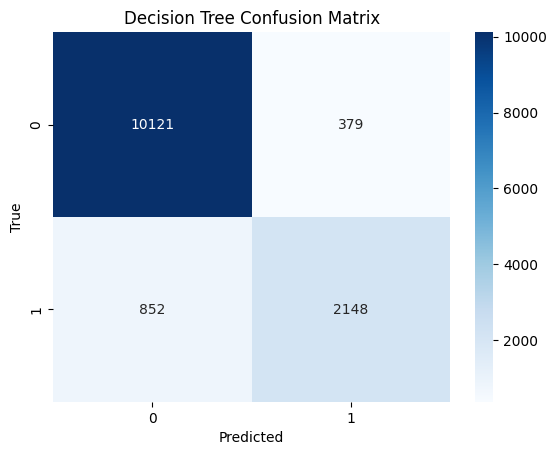

In [6]:
# 2. Decision Tree: Training und Evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Baum initialisieren und trainieren
dt = DecisionTreeClassifier(max_depth=5, random_state=SEED)
dt.fit(X_train, y_train)

# Vorhersage & Metriken
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


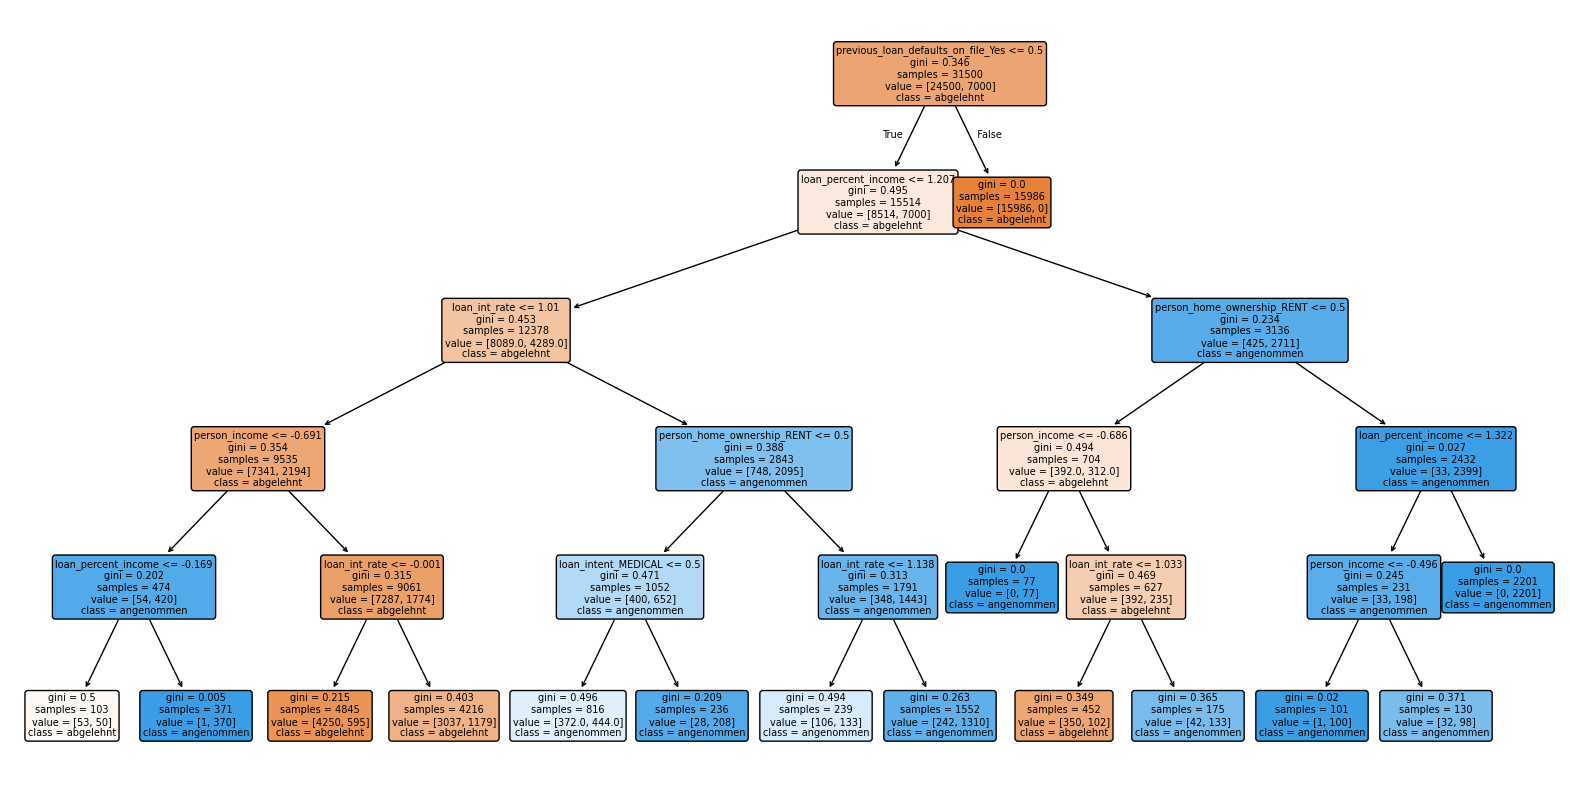

In [7]:
# 3. Decision Tree Visualisierung
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X_enc.columns,
    class_names=["abgelehnt", "angenommen"],
    filled=True,
    rounded=True,
    fontsize=7,
    # max_depth=3  # Anzeige der Top-3 Ebenen
)
plt.show()


c:\Users\JuliusSchmidt\Desktop\XAI_Prototyp\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test Accuracy: 0.9189


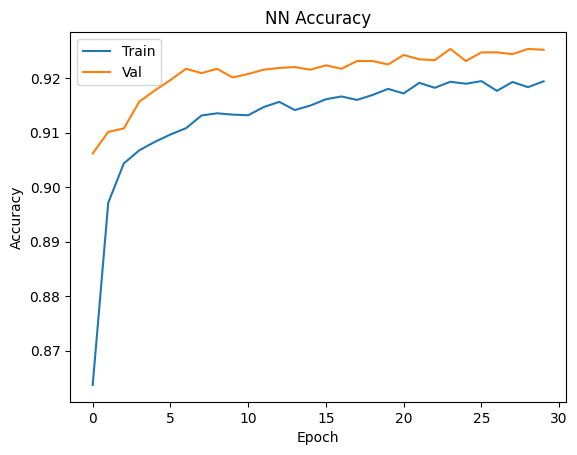

In [8]:
# 4. Black-Box Modell: Neuronales Netz trainieren

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Modellaufbau
nn = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

nn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Training
history = nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=0
)

# Evaluation
loss, acc = nn.evaluate(X_test, y_test, verbose=0)
print(f"NN Test Accuracy: {acc:.4f}")

# Lernkurven
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("NN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


PermutationExplainer explainer: 501it [01:32,  5.38it/s]                         


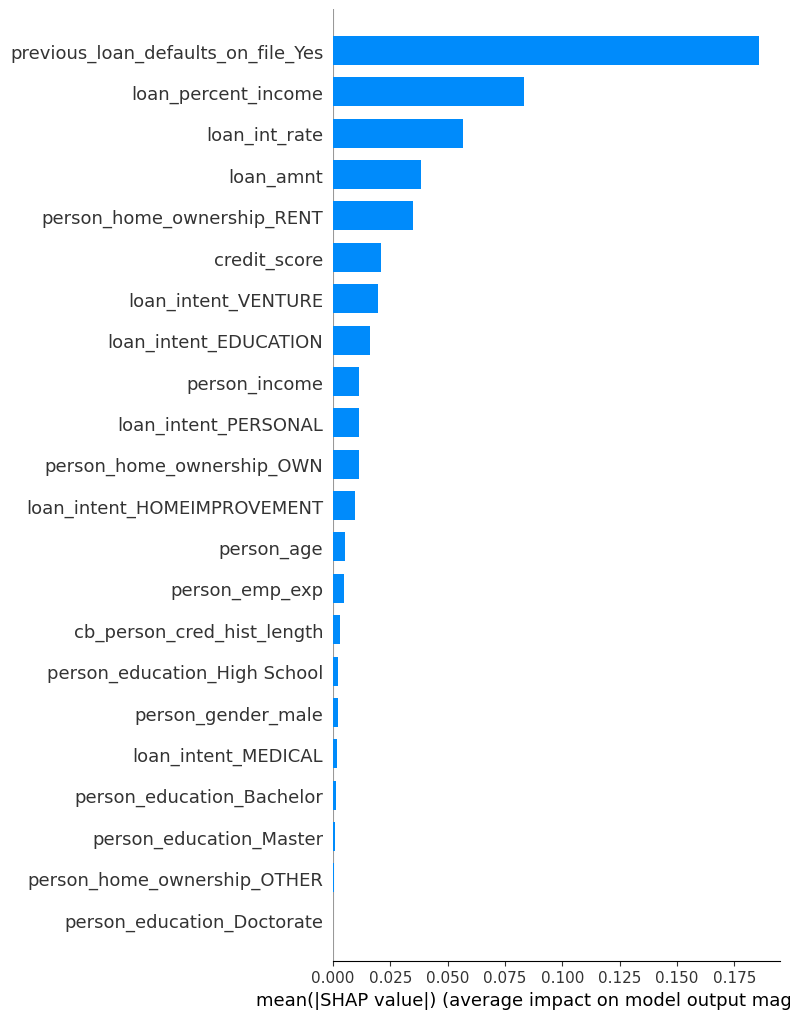

In [10]:
# compute SHAP values
explainer = shap.Explainer(nn, X_train32[:500])
shap_values = explainer(X_train32[:500])

shap.summary_plot(
    shap_values,
    features=shap_values,              # hier ebenfalls das numpy array
    feature_names=feature_names,
    plot_type="bar",
    max_display=25  # Optional: Anzahl der Features begrenzen
)

In [11]:
# 6. LIME (lokal)
from lime.lime_tabular import LimeTabularExplainer

def keras_predict_proba(x):
    # x ist ein numpy-array [n_samples, n_features]
    p1 = nn.predict(x)               # Form (n_samples,1)
    p0 = 1 - p1                      # P(class=0)
    return np.hstack([p0, p1])       # Form (n_samples,2) und P0+P1=1

explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_enc.columns.tolist(),
    class_names=["abgelehnt", "angenommen"],
    discretize_continuous=True,
)

# Beispiel-Instanz erklären
i = 12
exp = explainer_lime.explain_instance(
    X_test.values[i],
    keras_predict_proba,   # hier die neue Funktion
    num_features=10,
    top_labels=1
)

# Ermittle, welche Labels tatsächlich erklärt wurden
labels = exp.available_labels()  # z.B. [0] oder [1] oder [0,1]
print("Verfügbare Labels für diese Erklärung:", labels)

# Nehme das erste verfügbare Label
lbl = labels[0]

# als Liste ausgeben
for feature, weight in exp.as_list(label=lbl):
    print(f"{feature}: {weight:.4f}")
    
print(X_test.values[i])
# oder als HTML
from IPython.display import display, HTML
html = exp.as_html(labels=(lbl,), show_predicted_value=True, show_table=True)

# CSS vorne dran:
css = """
<style>
/* Erzwinge weißen Hintergrund für den LIME-Container */
.lime.explanation {
  background-color: white !important;
}
</style>
"""

display(HTML(css + html))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Verfügbare Labels für diese Erklärung: [0]
previous_loan_defaults_on_file_Yes <= 0.00: -0.3873
loan_percent_income > 0.58: -0.2061
person_home_ownership_OWN <= 0.00: -0.0976
loan_amnt > 0.42: 0.0759
loan_intent_VENTURE <= 0.00: -0.0611
person_home_ownership_RENT <= 0.00: 0.0594
loan_intent_EDUCATION <= 0.00: -0.0541
loan_intent_PERSONAL <= 0.00: -0.0394
person_home_ownership_OTHER <= 0.00: 0.0315
0.00 < loan_int_rate <= 0.68: -0.0198
[0.7007102502724476 0.310463174220878 1.0867823889307109
 2.4097046026308773 0.5114163134364397 1.1497944221524161
 -0.22359927706732838 0.2655133056274966 False True False False False
 False False False False False True False False False]


In [10]:
from sklearn.neighbors import NearestNeighbors

# 1) Fit auf alle Trainingsdaten (kodiert)
nnbrs = NearestNeighbors(n_neighbors=len(X_train)).fit(X_train)

# 1) Indizes finden (wie zuvor)
i = 5
dists, idxs = nnbrs.kneighbors([X_test.values[i]])
idxs_flat = idxs[0]
labels_flat = y_train.iloc[idxs_flat].values
pos0 = np.where(labels_flat == 0)[0][0]
pos1 = np.where(labels_flat == 1)[0][0]
nn0, nn1 = idxs_flat[pos0], idxs_flat[pos1]

# 2) Die drei Einträge ziehen (Rohdaten)
query_df = X_test_raw.iloc[i : i+1].copy()
query_df["loan_status"] = y_test.iloc[i]

nb0_df = X_train_raw.iloc[nn0 : nn0+1].copy()
nb0_df["loan_status"] = 0

nb1_df = X_train_raw.iloc[nn1 : nn1+1].copy()
nb1_df["loan_status"] = 1

# 3) Zusammenführen
comp_df = pd.concat([query_df, nb0_df, nb1_df], ignore_index=True)
comp_df.index = ["query", "neighbor_abgelehnt", "neighbor_akzeptiert"]

# 4) Highlight-Funktion
def highlight_diffs(col):
    ref = col.iloc[0]  # Wert der query
    return ["background-color: blue" if v != ref else "" for v in col]

# 5) Styler anwenden
comp_df.style.apply(highlight_diffs, axis=0)

c:\Users\JuliusSchmidt\Desktop\XIA_Prototyp\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
query,26.000000,male,Bachelor,61165.000000,1,MORTGAGE,10000.000000,EDUCATION,8.230000,0.160000,4.000000,667,Yes,0
neighbor_abgelehnt,25.000000,male,Bachelor,68057.000000,4,MORTGAGE,8000.000000,EDUCATION,7.660000,0.120000,4.000000,669,Yes,0
neighbor_akzeptiert,25.000000,male,Bachelor,57482.000000,5,MORTGAGE,12000.000000,EDUCATION,6.620000,0.210000,2.000000,640,No,1
